In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime




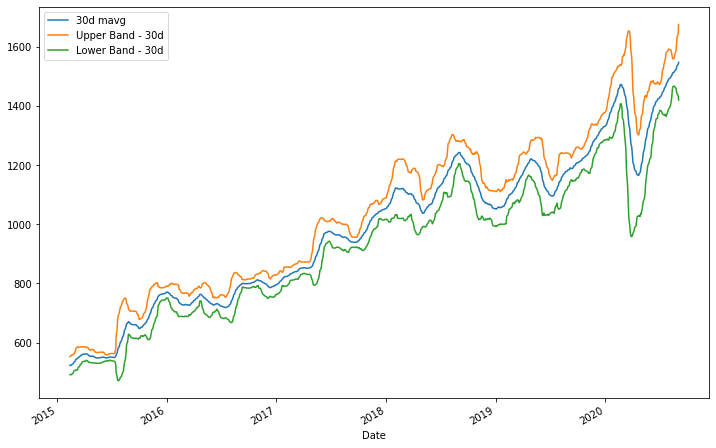

In [24]:
from datetime import date
today = date.today()
googledata = pdr.DataReader("GOOGL", 
                       start='2015-1-1', 
                       end=today, 
                       data_source='yahoo')
nasdaqdata = pdr.DataReader("^IXIC", 
                       start='2015-1-1', 
                       end=today, 
                       data_source='yahoo')

        
googledata['30d mavg'] = googledata['Adj Close'].rolling(window = 30).mean()
googledata['30d std'] = googledata['Adj Close'].rolling(window = 30).std()
googledata['Upper Band - 30d'] = googledata['30d mavg'] + 2 * googledata['30d std']
googledata['Lower Band - 30d'] = googledata['30d mavg'] - 2 * googledata['30d std']
googledata[['30d mavg', 'Upper Band - 30d', 'Lower Band - 30d']].plot(figsize=(12,8))







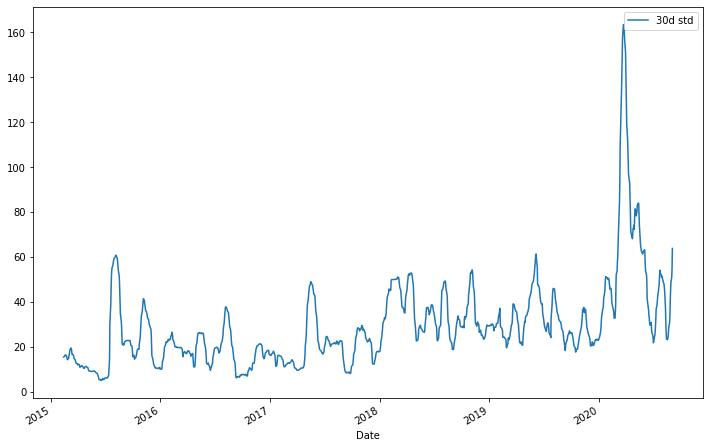

In [25]:
googledata[['30d std']].plot(figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020EAF2E7248>,
      dtype=object)

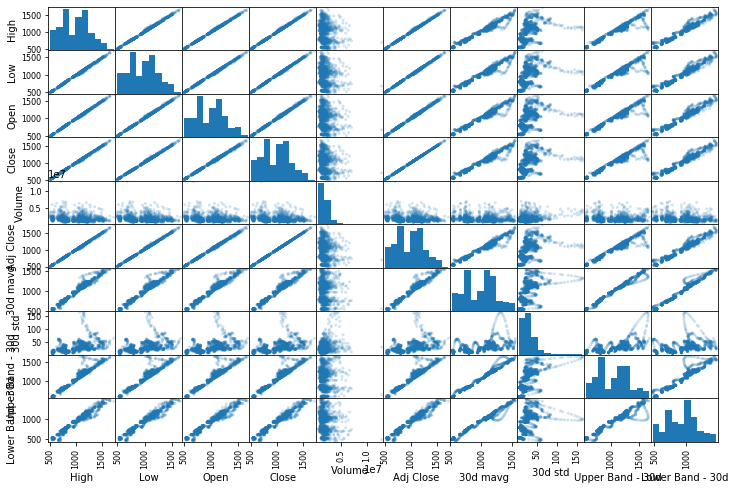

In [30]:
pd.plotting.scatter_matrix(googledata, alpha=0.2, figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020EB362DC08>,
      dtype=object)

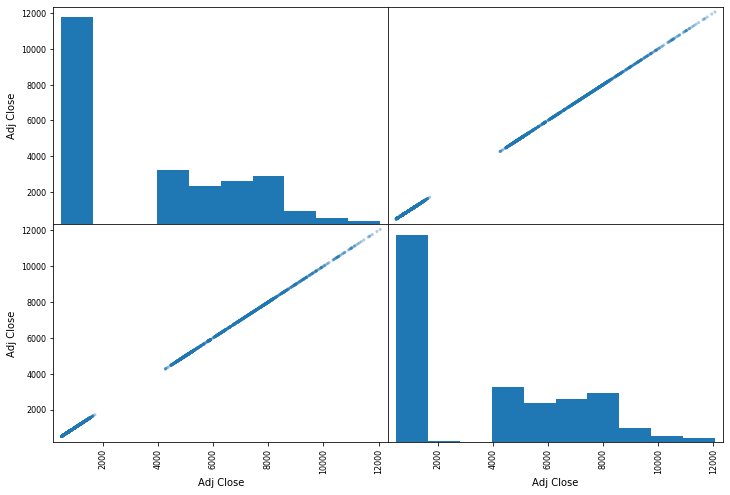

In [44]:
#adjClose = googledata[['Adj Close']].merge(nasdaqdata[['Adj Close']], how='outer', on)
adjconcat = pd.concat([googledata[['Adj Close']], nasdaqdata[['Adj Close']]], axis=1)
adjconcat
pd.plotting.scatter_matrix(adjconcat, alpha=0.2, figsize=(12,8))


# Stock Comparison

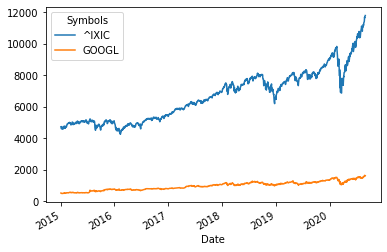

In [33]:
import pandas_datareader.data as web
dfcomp = web.DataReader(['^IXIC', 'GOOGL'], 'yahoo', start='2015-01-01', end='2020-08-31')['Adj Close']
dfcomp.plot()

# Dynamic Portfolio Function

# Load in Data

In [2]:
stocks = 'AAPL GLD'. split()
df = pdr.get_data_yahoo(stocks, '2019-01-01')['Close']
df.head()

Symbols          AAPL         GLD
Date                             
2019-01-02  39.480000  121.330002
2019-01-03  35.547501  122.430000
2019-01-04  37.064999  121.440002
2019-01-07  36.982498  121.860001
2019-01-08  37.687500  121.529999

In [17]:
#Two stocks per portfolio
def getPortfolioExpectedReturn(stocks, stocksWeight, stocksExpectedReturn):
    stock1 = stocks[0]
    stock2 = stocks[1]
    df = pdr.get_data_yahoo(stocks, '2019-01-01')['Close']
    df = df[-253:]
    df_vol = pd.DataFrame()
    for stock in stocks:
        if stock not in df_vol:
            df_vol[stock] = np.log(df[stock]).diff()
    
    #Calculate Variance
    var_stock1 = df_vol[stock1].var() * 252
    var_stock2 = df_vol[stock2].var() * 252
    # Anualize the covariance
    cov = np.cov(df_vol[stock1].iloc[1:], df_vol[stock2].iloc[1:])[0,1] * 252
    port_std = np.sqrt(var_stock1 * stocksWeight[0] **2 + var_stock2 * stocksWeight[1] ** 2 + 2 * cov * stocksWeight[0] * stocksWeight[1])
    expectedReturn = stocksWeight[0] * stocksExpectedReturn[0] + stocksWeight[1] * stocksExpectedReturn[1]
    print("Expected Return: " + str(expectedReturn))
    print("Expected volatility: " + str(port_std))
        
    

In [39]:
def draw_bollinger(stockTicker, start_date, end_date):
    stock = pdr.get_data_yahoo(stockTicker, start_date, end_date)
    stock['30d mavg'] = stock['Adj Close'].rolling(window = 30).mean()
    stock['30d std'] = stock['Adj Close'].rolling(window=21).std()
    stock['Upper Band'] = stock['30d mavg'] + 2 * stock['30d std']
    stock['Lower Band'] = stock['30d mavg'] - 2 * stock['30d std']
    
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    x_axis = stock[start_date:end_date].index.get_level_values(0)
    
    ax.fill_between(x_axis, stock[start_date:end_date]['Upper Band'], stock[start_date:end_date]['Lower Band'], color='grey')
    ax.plot(x_axis, stock[start_date:end_date]['Adj Close'], color='red', lw=2, label = 'Adj. Close')
    ax.plot(x_axis, stock[start_date:end_date]['30d mavg'], color='black', lw=2, label = '30d mavg')

    ax.set_title('30 Day Bollinger Band')
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price(USD)')
    ax.legend()
    plt.show();


In [19]:
getPortfolioExpectedReturn(['AAPL', 'GLD'],[0.15,0.8],[0.7,0.3])

Expected Return: 0.345
Expected volatility: 0.1670600449486508


In [44]:
getPortfolioExpectedReturn(['GOOGL', 'TSLA'],[0.15,0.4],[0.8,0.2])

Expected Return: 0.2
Expected volatility: 0.360282112030653


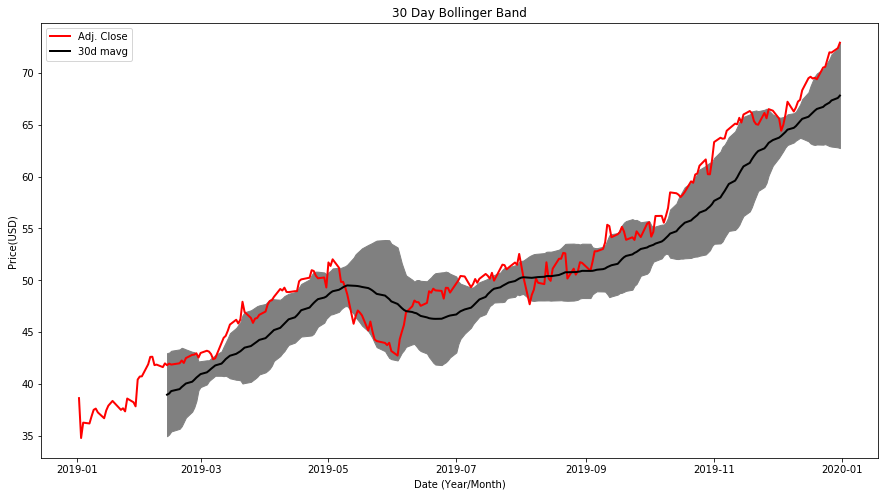

In [40]:
draw_bollinger('AAPL','2019', '2020')

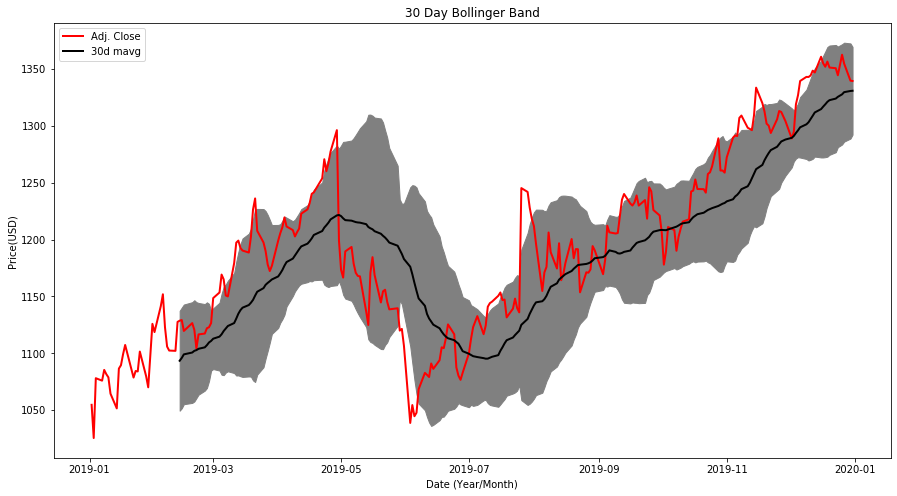

In [41]:
draw_bollinger('GOOGL','2019', '2020')

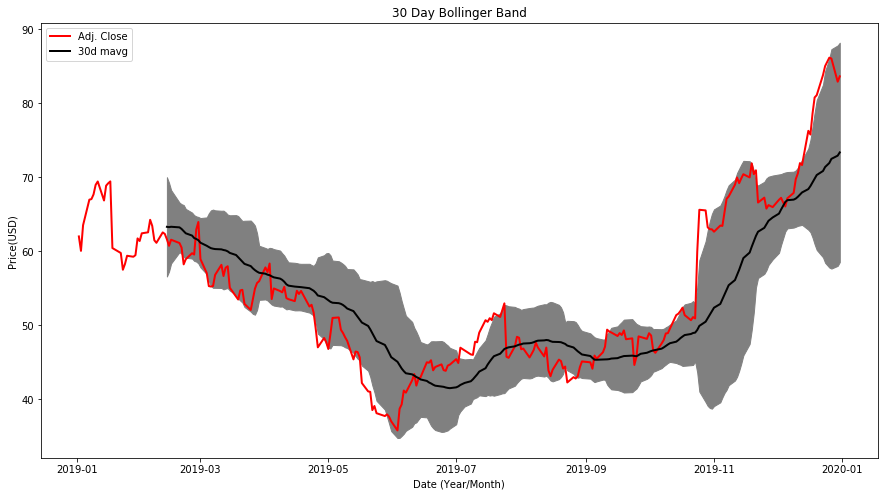

In [43]:
draw_bollinger('TSLA','2019', '2020')

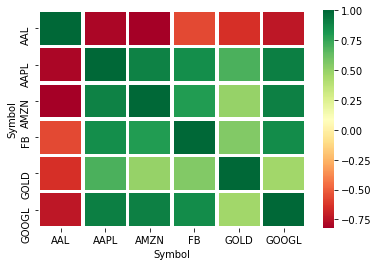

In [42]:
import numpy as np
import pandas as pd
#used to grab the stock prices, with yahoo
import pandas_datareader as pdr
from datetime import datetime
#to visualize the results
import matplotlib.pyplot as plt
import seaborn as sb

 
#select start date for correlation window as well as list of tickers
start = datetime(2017, 1, 1)
ticker_list = ['AAPL', 'FB', 'AAL', 'AMZN', 'GOOGL', 'GOLD']
#array to store prices
stocks=[]

#pull price using iex for each symbol in list defined above
for ticker in ticker_list:
    r = pdr.get_data_yahoo(ticker, start)
    # add a symbol column
    r['Symbol'] = ticker
    stocks.append(r)

# concatenate into df
df = pd.concat(stocks)
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df.head()

df_pivot = df.pivot('Date','Symbol','Close').reset_index()
df_pivot.head()

corr_df = df_pivot.corr(method='pearson')
sb.heatmap(corr_df, cmap='RdYlGn', linewidths=2.5)
plt.show()


